In [2]:
import pandas
import duckdb

In [3]:
import json

# 1. Open and load the JSON file
with open('config.json', 'r') as f:
    config_data = json.load(f)

# 2. Print it nicely
print("--- CONFIGURATION FILE CONTENT ---")
print(json.dumps(config_data, indent=4))

# 3. Example: Access a specific value
# If your config looks like {"database": {"host": "localhost"}}, you can do:
# print(config_data['database']['host'])

--- CONFIGURATION FILE CONTENT ---
{
    "Channels": {
        "Ambient Temperature": {
            "Frequency": 1,
            "Name": "Ambient Temperature"
        },
        "Brake Pos": {
            "Frequency": 50,
            "Name": "Brake Pos"
        },
        "Brake Pos Unfiltered": {
            "Frequency": 50,
            "Name": "Brake Pos Unfiltered"
        },
        "Brake Tickness": {
            "Frequency": 10,
            "Name": "Brake Tickness"
        },
        "Brakes Force": {
            "Frequency": 50,
            "Name": "Brakes Force"
        },
        "Brakes Temp": {
            "Frequency": 50,
            "Name": "Brakes Temp"
        },
        "Clutch Pos": {
            "Frequency": 50,
            "Name": "Clutch Pos"
        },
        "Clutch Pos Unfiltered": {
            "Frequency": 50,
            "Name": "Clutch Pos Unfiltered"
        },
        "Clutch RPM": {
            "Frequency": 100,
            "Name": "Clutch RPM"
        },


In [20]:

# 1. Connect to your file
con = duckdb.connect('my_data.duckdb')

# 2. List all tables
print("\n--- TABLES IN DATABASE ---")
tables = con.execute("SHOW TABLES").df()
print(tables.to_string(index=True))




--- TABLES IN DATABASE ---
                          name
0                          ABS
1                     ABSLevel
2          Ambient Temperature
3          AntiStall Activated
4                 Best LapTime
5                 Best Sector1
6                 Best Sector2
7              Brake Bias Rear
8              Brake Migration
9                    Brake Pos
10        Brake Pos Unfiltered
11                Brakes Force
12                 Brakes Temp
13               CloudDarkness
14                  Clutch Pos
15       Clutch Pos Unfiltered
16                  Clutch RPM
17             Current LapTime
18              Current Sector
19             Current Sector1
20             Current Sector2
21                        Drag
22              Engine Max RPM
23             Engine Oil Temp
24                  Engine RPM
25           Engine Water Temp
26                  FFB Output
27               Finish Status
28          Front3rdDeflection
29              FrontDownForce
30         

In [21]:
table_name = "GPS Time"

schema_df = con.execute(f'DESCRIBE "{table_name}"').df()
schema_df

,column_name,column_type,null,key,default,extra
0,value,DOUBLE,YES,None,None,None


In [1]:
# 2. Loop through tables with proper quoting
for table_name in tables['name']:
    print(f"\n--- PREVIEW: {table_name} ---")
    
    # FIX: Add double quotes around {table_name} to handle spaces
    # We use single quotes '...' for the f-string so we can use double quotes "..." inside
    print("Schema:")
    schema_df = con.execute(f'DESCRIBE "{table_name}"').df()
    print(schema_df)
    
    print("Data Sample:")
    data_df = con.execute(f'SELECT * FROM "{table_name}" LIMIT 3').df()
    print(data_df)

NameError: name 'tables' is not defined

In [22]:
import duckdb
import json
import pandas as pd

# 1. Setup
con = duckdb.connect('my_data.duckdb')
with open('config.json', 'r') as f:
    config = json.load(f)

def get_data_with_time(channel_name):
    """
    Fetches data for a specific channel and calculates the time axis 
    based on the frequency found in config.json.
    """
    # A. Find the frequency
    if channel_name in config['Channels']:
        freq = config['Channels'][channel_name]['Frequency']
    else:
        # Default to 1Hz or print error if not found
        print(f"Warning: {channel_name} has no frequency in config. Assuming 60Hz.")
        freq = 60

    # B. Construct the query
    # We create a 'SessionTime' column by dividing RowNumber by Frequency
    query = f"""
    SELECT 
        (row_number() OVER () - 1) / {freq}::FLOAT as SessionTime, 
        value as {channel_name.replace(' ', '_')}
    FROM "{channel_name}"
    """
    
    return con.execute(query).df()

# --- EXAMPLE USAGE ---

# Get RPM (100 Hz)
df_rpm = get_data_with_time("Engine RPM")

# Get Throttle (50 Hz)
df_throttle = get_data_with_time("Throttle Pos")

print("--- RPM DATA ---")
print(df_rpm.head())

print("\n--- THROTTLE DATA ---")
print(df_throttle.head())

--- RPM DATA ---
   SessionTime   Engine_RPM
0         0.00  4105.505371
1         0.01  4025.054932
2         0.02  3948.784668
3         0.03  3872.798828
4         0.04  3795.276123

--- THROTTLE DATA ---
   SessionTime  Throttle_Pos
0         0.00     32.806602
1         0.02     31.588343
2         0.04     30.478292
3         0.06     29.498920
4         0.08     28.934557


In [23]:
import duckdb
import json
import pandas as pd

con = duckdb.connect('my_data.duckdb')
with open('config.json', 'r') as f:
    config = json.load(f)

def get_channel_df(channel_name):
    # 1. Get Frequency
    if channel_name in config['Channels']:
        freq = config['Channels'][channel_name]['Frequency']
    else:
        freq = 60 # Default fallback
        
    # 2. Get Data with Calculated Time
    # We round time to 3 decimal places to avoid floating point mismatch during merge
    query = f"""
    SELECT 
        ROUND((row_number() OVER () - 1) / {freq}::FLOAT, 3) as Time, 
        value as "{channel_name}"
    FROM "{channel_name}"
    """
    return con.execute(query).df()

# --- STEP 1: LOAD CHANNELS ---
# Pick the channels you actually care about
df_rpm = get_channel_df("Engine RPM")       # 100Hz
df_speed = get_channel_df("GPS Speed")      # 10Hz (Based on your config)
df_throttle = get_channel_df("Throttle Pos") # 50Hz

# --- STEP 2: MERGE THEM ---
# We use 'outer' join to keep all timestamps, then sort by time
master_df = df_rpm.merge(df_speed, on='Time', how='outer')
master_df = master_df.merge(df_throttle, on='Time', how='outer')

# Sort by time so the rows are in order
master_df = master_df.sort_values('Time').reset_index(drop=True)

# --- STEP 3: FILL GAPS (FORWARD FILL) ---
# Because Speed is only 10Hz, it will have NaN (empty) values for 9 out of 10 rows.
# 'ffill' propagates the last known valid speed forward until a new one appears.
master_df = master_df.ffill()

print(master_df.head(20))

    Time   Engine RPM  GPS Speed  Throttle Pos
0   0.00  4105.505371   6.461850     32.806602
1   0.01  4025.054932   6.461850     32.806602
2   0.02  3948.784668   6.461850     31.588343
3   0.03  3872.798828   6.461850     31.588343
4   0.04  3795.276123   6.461850     30.478292
5   0.05  3715.431885   6.461850     30.478292
6   0.06  3632.785645   6.461850     29.498920
7   0.07  3548.097900   6.461850     29.498920
8   0.08  3462.326660   6.461850     28.934557
9   0.09  3378.530762   6.461850     28.934557
10  0.10  3303.433594   7.150851     28.762257
11  0.11  3234.637939   7.150851     28.762257
12  0.12  3168.235352   7.150851     28.845177
13  0.13  3102.960938   7.150851     28.845177
14  0.14  3038.080078   7.150851     28.845177
15  0.15  2974.315430   7.150851     28.845177
16  0.16  2912.352051   7.150851     28.845177
17  0.17  2856.008789   7.150851     28.845177
18  0.18  2821.684814   7.150851     28.867388
19  0.19  2811.593018   7.150851     28.867388


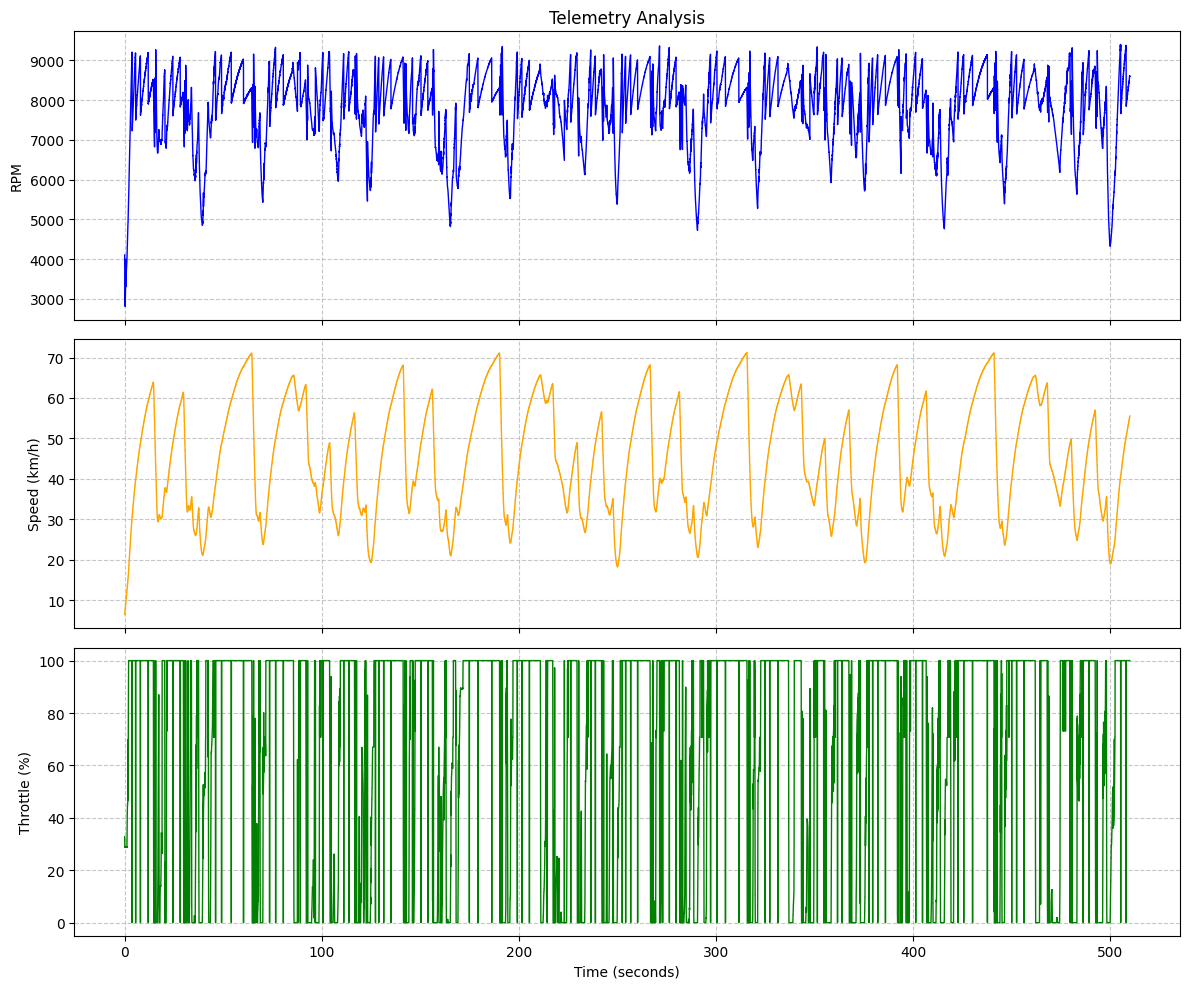

In [26]:
import matplotlib.pyplot as plt

# Create a figure with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# 1. Plot RPM
axs[0].plot(master_df['Time'], master_df['Engine RPM'], color='blue', linewidth=1)
axs[0].set_ylabel('RPM')
axs[0].set_title('Telemetry Analysis')
axs[0].grid(True, which='both', linestyle='--', alpha=0.7)

# 2. Plot Speed
axs[1].plot(master_df['Time'], master_df['GPS Speed'], color='orange', linewidth=1)
axs[1].set_ylabel('Speed (km/h)')
axs[1].grid(True, which='both', linestyle='--', alpha=0.7)

# 3. Plot Throttle
axs[2].plot(master_df['Time'], master_df['Throttle Pos'], color='green', linewidth=1)
axs[2].set_ylabel('Throttle (%)')
axs[2].set_xlabel('Time (seconds)')
axs[2].grid(True, which='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
import duckdb
import json
import pandas as pd
from functools import reduce

# 1. Setup Connection and Load Config
con = duckdb.connect('my_data.duckdb')
with open('config.json', 'r') as f:
    config = json.load(f)

# 2. Define the extraction function
def get_channel_df(channel_name):
    # Safe check: if channel not in config, skip or default
    if channel_name not in config['Channels']:
        return None
        
    freq = config['Channels'][channel_name]['Frequency']
    
    # We round to 3 decimal places (1ms) to ensure timestamps align correctly 
    # between different sensors (e.g. 100Hz vs 50Hz)
    query = f"""
    SELECT 
        ROUND((row_number() OVER () - 1) / {freq}::FLOAT, 3) as Time, 
        value as "{channel_name}"
    FROM "{channel_name}"
    """
    try:
        return con.execute(query).df()
    except Exception as e:
        print(f"Skipping {channel_name}: {e}")
        return None

# 3. Extract ALL Channels
print("Extracting channels...")
data_frames = []

# Loop through every key in the 'Channels' section of your config
for channel in config['Channels'].keys():
    df = get_channel_df(channel)
    if df is not None and not df.empty:
        data_frames.append(df)

print(f"Successfully extracted {len(data_frames)} channels.")

# 4. Merge Everything (The Heavy Lifting)
# We merge on 'Time' using an 'outer' join so we don't lose data 
# if one sensor has more timestamps than another.
if data_frames:
    print("Merging data... this might take a moment.")
    master_df = reduce(lambda left, right: pd.merge(left, right, on='Time', how='outer'), data_frames)
    
    # 5. Clean Up
    master_df = master_df.sort_values('Time').reset_index(drop=True)
    master_df = master_df.ffill() # Forward fill gaps
    
    print("Done!")
    print(master_df.head())
else:
    print("No data found.")

In [28]:
master_df

,Time,Ambient Temperature,Brake Pos,Brake Pos Unfiltered,Clutch Pos,Clutch Pos Unfiltered,Clutch RPM,Drag,Engine Oil Temp,Engine RPM,...,Throttle Pos Unfiltered,Time Behind Next,Total Dist,Track Edge,Track Temperature,Turbo Boost Pressure,Virtual Energy,Wind Heading,Wind Speed,Yaw Rate
0,0.000000,22.001593,0.0,0.0,0.0,0.0,4105.505371,26.701820,78.971535,4105.505371,...,48.965080,0.0,0.001000,10.875,42.999992,101325.0,7.350000e+10,4.712389,1.0,-61.295124
1,0.010000,22.001593,0.0,0.0,0.0,0.0,4025.054932,27.243486,78.971535,4025.054932,...,48.965080,0.0,0.001000,10.875,42.999992,101325.0,7.350000e+10,4.712389,1.0,-59.246861
2,0.020000,22.001593,0.0,0.0,0.0,0.0,3948.784668,27.800257,78.971535,3948.784668,...,47.146782,0.0,0.001000,10.875,42.999992,101325.0,7.350000e+10,4.712389,1.0,-58.359722
3,0.030000,22.001593,0.0,0.0,0.0,0.0,3872.798828,28.379175,78.971535,3872.798828,...,47.146782,0.0,0.001000,10.875,42.999992,101325.0,7.350000e+10,4.712389,1.0,-58.206051
4,0.040000,22.001593,0.0,0.0,0.0,0.0,3795.276123,28.973186,78.971535,3795.276123,...,45.489986,0.0,0.001000,10.875,42.999992,101325.0,7.350000e+10,4.712389,1.0,-57.368347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54066,510.571014,22.069811,0.0,0.0,0.0,0.0,8609.816406,1953.039551,87.914665,8609.816406,...,100.000000,0.0,23094.050781,7.325,40.999992,101325.0,7.350000e+10,4.712389,1.0,-2.320259
54067,510.713989,22.069811,0.0,0.0,0.0,0.0,8609.816406,1953.039551,87.918312,8609.816406,...,100.000000,0.0,23094.050781,7.325,40.999992,101325.0,7.350000e+10,4.712389,1.0,-2.320259
54068,510.856995,22.069811,0.0,0.0,0.0,0.0,8609.816406,1953.039551,87.921951,8609.816406,...,100.000000,0.0,23094.050781,7.325,40.999992,101325.0,7.350000e+10,4.712389,1.0,-2.320259
54069,511.000000,22.069811,0.0,0.0,0.0,0.0,8609.816406,1953.039551,87.925583,8609.816406,...,100.000000,0.0,23094.050781,7.325,40.999992,101325.0,7.350000e+10,4.712389,1.0,-2.320259


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_telemetry(df, channels, time_col='Time'):
    """
    Plots multiple telemetry channels from the master DataFrame.
    
    Parameters:
    - df: The master DataFrame containing the data.
    - channels: A list of strings representing the column names to plot.
    - time_col: The name of the time column (default is 'Time').
    """
    
    # Check if channels exist in the dataframe to avoid errors
    valid_channels = [c for c in channels if c in df.columns]
    missing_channels = [c for c in channels if c not in df.columns]
    
    if missing_channels:
        print(f"⚠️ Warning: These channels were not found and will be skipped: {missing_channels}")
    
    if not valid_channels:
        print("❌ No valid channels to plot.")
        return

    # Create subplots (stacked vertically)
    n = len(valid_channels)
    fig, axs = plt.subplots(n, 1, figsize=(15, 3 * n), sharex=True)
    
    # If there is only 1 channel, axs is not a list, so we wrap it in a list
    if n == 1:
        axs = [axs]

    # Loop through each channel and plot it
    for i, channel in enumerate(valid_channels):
        ax = axs[i]
        
        # Plot the data
        ax.plot(df[time_col], df[channel], linewidth=1)
        
        # Styling
        ax.set_ylabel(channel, fontsize=10, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Highlight zero line if data goes negative (like Yaw Rate)
        if df[channel].min() < 0 and df[channel].max() > 0:
            ax.axhline(0, color='black', linewidth=0.8, alpha=0.5)

    # Label the X-axis only on the bottom chart
    axs[-1].set_xlabel('Time (seconds)', fontsize=12)
    axs[0].set_title('Telemetry Analysis', fontsize=14)
    
    plt.tight_layout()
    plt.show()

⚠️ Warning: These channels were not found and will be skipped: ['TyresTempCentre']


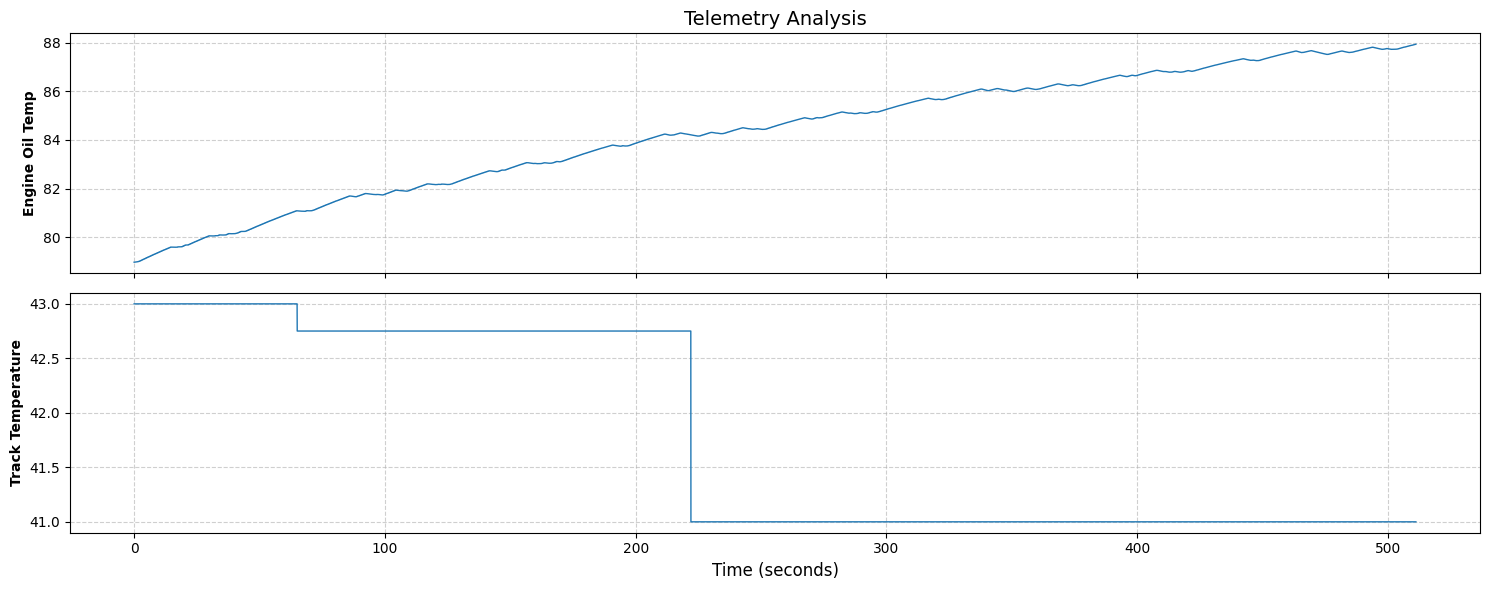

In [31]:
plot_telemetry(master_df, ['Engine Oil Temp', 'Track Temperature', 'TyresTempCentre'])

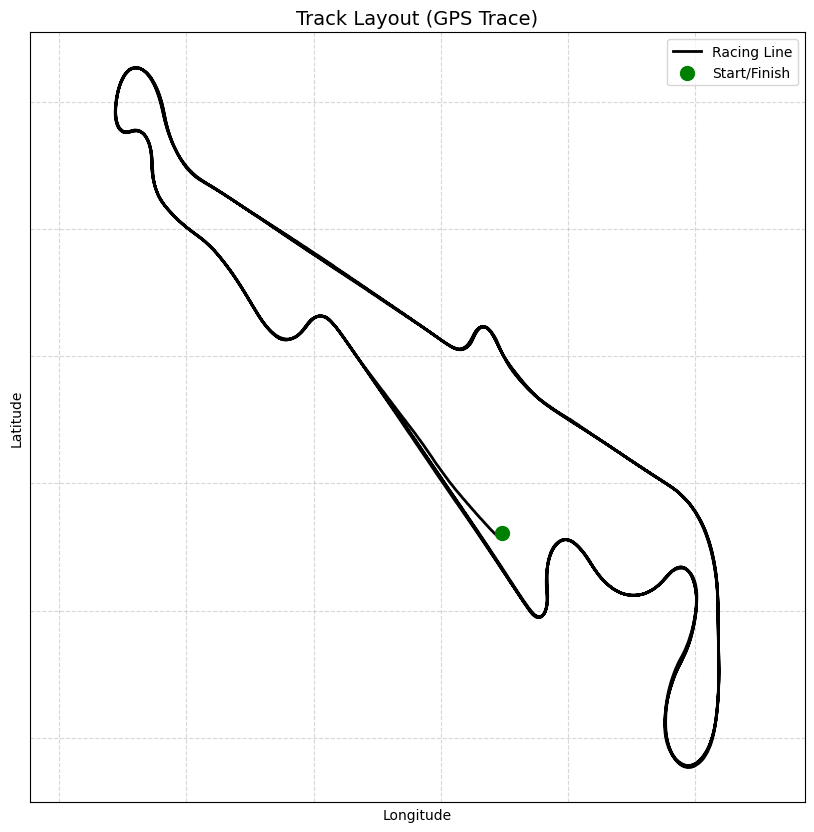

In [32]:
import matplotlib.pyplot as plt

def plot_track_map(df):
    """
    Plots the GPS Latitude vs Longitude to visualize the track layout.
    """
    # Check if we have the necessary columns
    if 'GPS Latitude' not in df.columns or 'GPS Longitude' not in df.columns:
        print("❌ Error: GPS Latitude or Longitude columns are missing.")
        return

    plt.figure(figsize=(10, 10))
    
    # Plot the path
    # We invert the X-axis (Longitude) because sometimes raw GPS plots mirror the track 
    # depending on the coordinate system. If it looks backwards, remove .invert_xaxis()
    plt.plot(df['GPS Longitude'], df['GPS Latitude'], color='black', linewidth=2, label='Racing Line')
    
    # Mark the Start/Finish line (First point)
    start_lat = df['GPS Latitude'].iloc[0]
    start_lon = df['GPS Longitude'].iloc[0]
    plt.scatter(start_lon, start_lat, color='green', s=100, label='Start/Finish', zorder=5)

    # Styling
    plt.title('Track Layout (GPS Trace)', fontsize=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # CRITICAL: Keep the aspect ratio equal so the track isn't squashed
    plt.axis('equal')
    
    # Optional: Turn off axis numbers for a cleaner look
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    plt.show()

# --- RUN IT ---
plot_track_map(master_df)

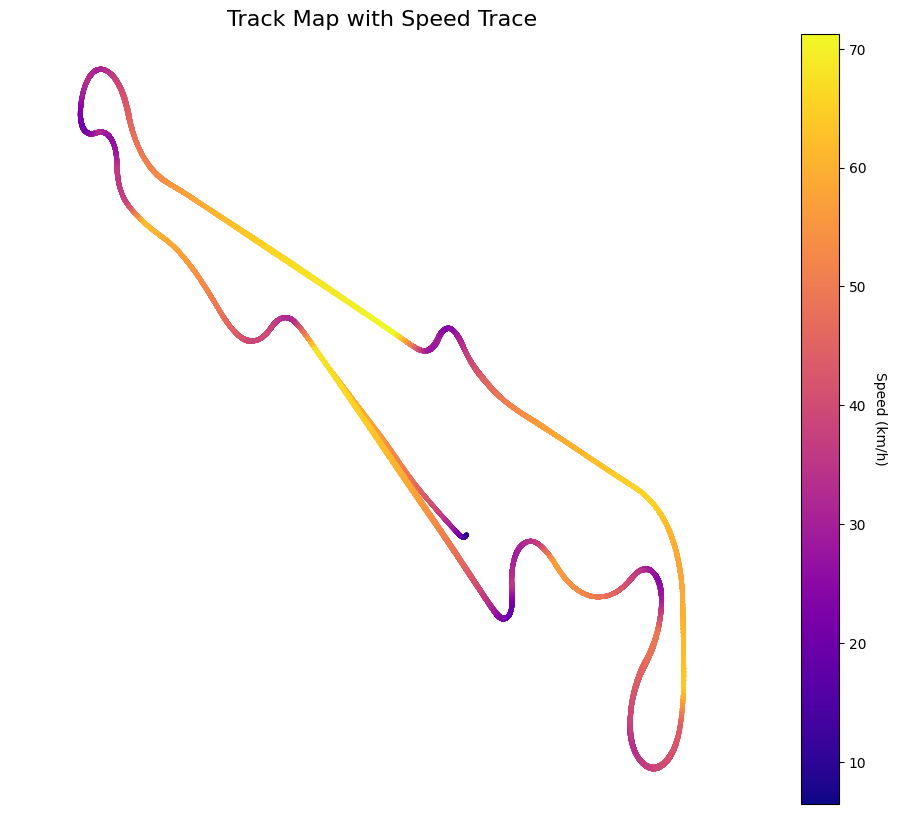

In [33]:
def plot_track_heatmap(df):
    plt.figure(figsize=(12, 10))
    
    # We use a scatter plot because it allows us to color each point individually
    # c=df['GPS Speed'] maps the color to speed
    # cmap='plasma' sets the color scheme (Blue=Slow, Yellow=Fast)
    sc = plt.scatter(df['GPS Longitude'], df['GPS Latitude'], 
                     c=df['GPS Speed'], cmap='plasma', s=5)
    
    # Add a colorbar to show what the colors mean
    cbar = plt.colorbar(sc)
    cbar.set_label('Speed (km/h)', rotation=270, labelpad=15)
    
    plt.title('Track Map with Speed Trace', fontsize=16)
    plt.axis('equal')
    plt.axis('off') # Hides the box/numbers completely
    
    plt.show()

# --- RUN IT ---
plot_track_heatmap(master_df)

In [39]:
master_df["Time"]

0          0.000000
1          0.010000
2          0.020000
3          0.030000
4          0.040000
            ...    
54066    510.571014
54067    510.713989
54068    510.856995
54069    511.000000
54070    511.143005
Name: Time, Length: 54071, dtype: float32

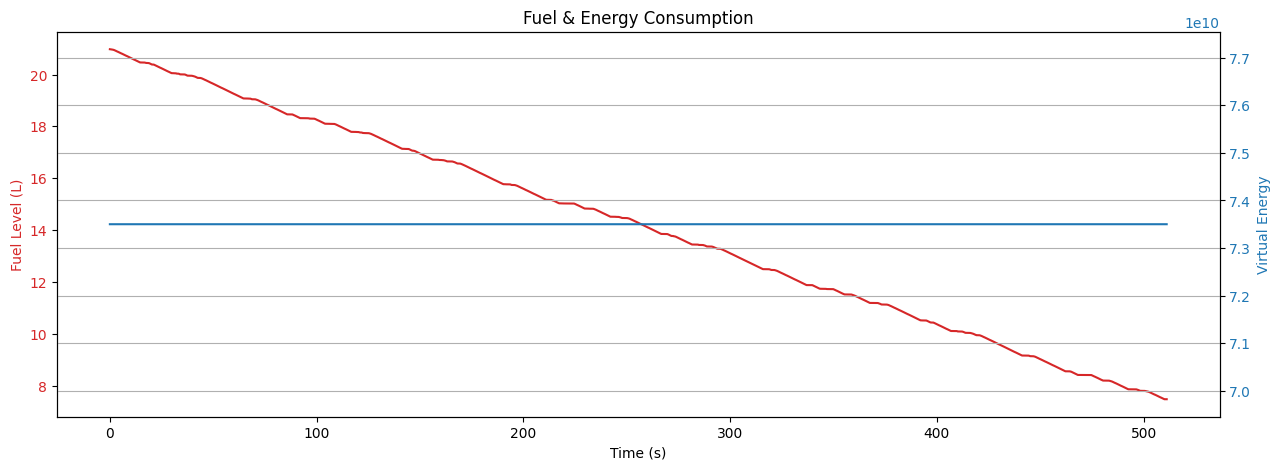

In [38]:
def plot_energy(df):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    # Plot Fuel on Left Axis
    color = 'tab:red'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Fuel Level (L)', color=color)
    ax1.plot(df['Time'], df['Fuel Level'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create a second Y-axis for Battery/Energy if it exists
    if 'Virtual Energy' in df.columns:
        ax2 = ax1.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('Virtual Energy', color=color)  
        ax2.plot(df['Time'], df['Virtual Energy'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        
    plt.title("Fuel & Energy Consumption")
    plt.grid(True)
    plt.show()

plot_energy(master_df)

In [43]:
# Alternative Merge Strategy (if asof fails)
df_lap = con.execute('SELECT * FROM "Lap"').df()
display(df_lap.head())
# Ensure standard column names
if 'SessionTime' in df_lap.columns:
    df_lap = df_lap.rename(columns={'SessionTime': 'Time', 'value': 'Lap'})

df_lap

,ts,value
0,79.2150,0
1,99.2025,0
2,119.2050,0
3,139.2050,0
4,159.2050,0


,ts,value
0,79.2150,0
1,99.2025,0
2,119.2050,0
3,139.2050,0
4,159.2050,0
...,...,...
60,569.1975,3
61,579.2050,0
62,579.2050,1
63,589.1975,2


In [45]:
master_df.columns

Index(['Time', 'Ambient Temperature', 'Brake Pos', 'Brake Pos Unfiltered',
       'Clutch Pos', 'Clutch Pos Unfiltered', 'Clutch RPM', 'Drag',
       'Engine Oil Temp', 'Engine RPM', 'Engine Water Temp', 'FFB Output',
       'Front3rdDeflection', 'FrontDownForce', 'FrontRideHeight',
       'FrontWingHeight', 'Fuel Level', 'G Force Lat', 'G Force Long',
       'G Force Vert', 'GPS Latitude', 'GPS Longitude', 'GPS Speed',
       'GPS Time', 'Ground Speed', 'Lap Dist', 'Lateral Acceleration',
       'Longitudinal Acceleration', 'OverheatingState', 'Path Lateral',
       'ReadDownForce', 'Rear3rdDeflection', 'RearRideHeight', 'Regen Rate',
       'SoC', 'Steered Angle', 'Steering Pos', 'Steering Pos Unfiltered',
       'Steering Shaft Torque', 'Throttle Pos', 'Throttle Pos Unfiltered',
       'Time Behind Next', 'Total Dist', 'Track Edge', 'Track Temperature',
       'Turbo Boost Pressure', 'Virtual Energy', 'Wind Heading', 'Wind Speed',
       'Yaw Rate'],
      dtype='object')

In [47]:
master_df["Lap Dist"]

0           0.001000
1           0.001000
2           0.001000
3           0.001000
4           0.001000
            ...     
54066    5672.200195
54067    5672.200195
54068    5672.200195
54069    5672.200195
54070    5672.200195
Name: Lap Dist, Length: 54071, dtype: float32

In [49]:
import pandas as pd
import numpy as np

# 1. Rename columns in df_lap to be clear (if not done already)
df_lap = df_lap.rename(columns={'ts': 'GPS_Timestamp', 'value': 'Lap'})

# 2. Find the Offset (The "Zero Point") from the master_df
start_offset = master_df['GPS Time'].iloc[0]
print(f"⏱️ Session started at GPS Time: {start_offset}")

# 3. Align the Lap Data
df_lap['Time'] = df_lap['GPS_Timestamp'] - start_offset

# 4. Clean up
df_lap = df_lap[df_lap['Time'] >= 0].sort_values('Time')

# --- THE FIX STARTS HERE ---
# Convert 'Time' in both dataframes to float64 to ensure they match perfectly
master_df['Time'] = master_df['Time'].astype('float64')
df_lap['Time'] = df_lap['Time'].astype('float64')
# ---------------------------

# 5. Merge into Master DF
master_df = master_df.sort_values('Time')
master_df = pd.merge_asof(master_df, df_lap[['Time', 'Lap']], on='Time', direction='backward')

# Fill any gaps at the start with 0
master_df['Lap'] = master_df['Lap'].fillna(0)

print("\n✅ Lap Merging Complete!")
print("Unique Laps Found:", master_df['Lap'].unique())

⏱️ Session started at GPS Time: 79.1725

✅ Lap Merging Complete!
Unique Laps Found: [0. 1. 2. 3.]


In [52]:
master_df["Lap"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
54066    3.0
54067    3.0
54068    3.0
54069    3.0
54070    3.0
Name: Lap, Length: 54071, dtype: float64

In [73]:
import duckdb
import pandas as pd
import numpy as np

def calculate_telemetry(con):
    """
    Fetches telemetry data and calculates derived metrics (Speed, Lap) using Pandas.
    
    Args:
        con: An active DuckDB connection object.
    """
    
    print("--- 1. Simple SQL Fetch ---")
    # We fetch the raw data sorted by SessionTime.
    # Using 'SessionTime' and 'LapDist' as the correct channel names from the database.
    query = """
    SELECT 
        SessionTime, 
        LapDist 
    FROM telemetry 
    ORDER BY SessionTime
    """
    
    # Execute query and load into Pandas DataFrame
    df = con.execute(query).df()

    print(f"Fetched {len(df)} rows.")

    print("--- 2. Pandas Processing (Laps & Speed) ---")
    
    # A. Calculate Deltas
    # diff() calculates the difference between current row and previous row
    df['d_time'] = df['SessionTime'].diff()
    df['d_dist'] = df['LapDist'].diff()

    # B. Lap Detection
    # If LapDist decreases (negative delta), a new lap has started (reset to 0).
    df['Is_New_Lap'] = df['d_dist'] < 0
    
    # Start at Lap 1, add 1 for every time 'Is_New_Lap' is True
    df['Lap'] = df['Is_New_Lap'].cumsum() + 1

    # C. Speed Calculation (Distance / Time)
    # Basic Speed = d_dist / d_time (m/s)
    # We avoid division by zero or tiny timestamps
    df['Speed_ms'] = df['d_dist'] / df['d_time']

    # D. Data Cleaning
    # 1. Handle the first row (NaNs from diff)
    df.fillna(0, inplace=True)
    
    # 2. Handle Speed spikes at Lap Line
    # When a new lap starts, d_dist is negative (e.g. 5000m -> 0m).
    # This results in a massive negative speed. We filter this out.
    df.loc[df['d_dist'] < 0, 'Speed_ms'] = np.nan
    
    # Forward-fill the speed to cover the nan gap at the lap line
    df['Speed_ms'] = df['Speed_ms'].ffill()

    # Optional: Convert to kph for readability
    df['Speed_kph'] = df['Speed_ms'] * 3.6

    # Display a sample of the results
    print(df[['SessionTime', 'LapDist', 'Lap', 'Speed_kph']].head(20))
    
    return df

if __name__ == "__main__":
    # Example usage with an existing database file
    try:
        # Establish the connection here, mimicking the main application flow
        con = duckdb.connect('my_data.duckdb')
        
        # Run the calculation
        df_result = calculate_telemetry(con)
        
        # Close connection
        con.close()
    except Exception as e:
        print(f"Error: {e}")
        print("Ensure 'telemetry.db' exists and contains the 'telemetry' table with 'SessionTime' and 'LapDist'.")

--- 1. Simple SQL Fetch ---
Error: Catalog Error: Table with name telemetry does not exist!
Did you mean "sqlite_master"?

LINE 5:     FROM telemetry 
                 ^
Ensure 'telemetry.db' exists and contains the 'telemetry' table with 'SessionTime' and 'LapDist'.
